# Trabalho Computacional 2. Perceptron Multicamada no problema MNIST
Rodrigo Fonseca Torreão
211066196


## 1. Introdução e Preparação
Aqui importamos as dependências e definimos a classe do dataset MNIST

In [1]:
import torch
import torchvision
from torchvision import transforms
from d2l import torch as d2l
from torch import nn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
class MNIST(d2l.DataModule):  #@save
    """The Fashion-MNIST dataset."""
    def __init__(self, batch_size=256, resize=(28, 28)):
        super().__init__()
        self.save_hyperparameters()
        trans = transforms.Compose([transforms.Resize(resize),
                                    transforms.ToTensor()])
        self.train = torchvision.datasets.MNIST(
            root=self.root, train=True, transform=trans, download=True)
        self.val = torchvision.datasets.MNIST(
            root=self.root, train=False, transform=trans, download=True)
    def visualize(self, batch, nrows=1, ncols=8, labels=[]):
        """Defined in :numref:`sec_fashion_mnist`"""
        X, y = batch
        if not labels:
            labels = ""
        d2l.show_images(X.squeeze(1), nrows, ncols, titles=labels)

In [3]:
dataset = MNIST()

In [4]:
@d2l.add_to_class(MNIST)  #@save
def get_dataloader(self, train):
    data = self.train if train else self.val
    return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train,
                                       num_workers=self.num_workers)

def evaluate_accuracy(model, data_iter):
	model.eval()
	metric = d2l.Accumulator(2)
	with torch.no_grad():		
		for X, y in data_iter:
			metric.add(d2l.accuracy(model(X), y), y.numel())
	model.train()
	return metric[0] / metric[1]

## 2. Modelos e Arquiteturas
Nesta seção treinaremos diferentes tipos de arquiteturas diferentes e validaremos sua precisão
### 2a) Perceptron com uma camada escondida, função de ativação sigmoide e otimização por descida de gradiente.


In [5]:
class MLP_1(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(nn.Flatten(), nn.LazyLinear(num_hiddens),
                                 nn.Sigmoid(), nn.LazyLinear(num_outputs))

Final validation accuracy:  0.9149


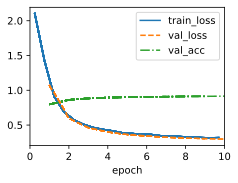

In [6]:
model = MLP_1(num_outputs=10, num_hiddens=128, lr=0.1)
data = dataset
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)
print('Final validation accuracy: ', evaluate_accuracy(model, data.val_dataloader()))

### 2b) Otimizador Adam

In [7]:
class MLP_Adam(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(nn.Flatten(), nn.LazyLinear(num_hiddens),
                                 nn.Sigmoid(), nn.LazyLinear(num_outputs))
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)


Final validation accuracy:  0.9446


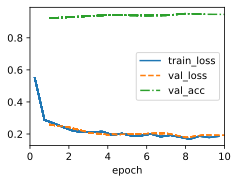

In [8]:
model_Adam = MLP_Adam(num_outputs=10, num_hiddens=128, lr=0.1)
trainer_Adam = d2l.Trainer(max_epochs=10)
trainer_Adam.fit(model_Adam, data)
print('Final validation accuracy: ', evaluate_accuracy(model_Adam, data.val_dataloader()))

### 2c) Otimizador ReLU


In [9]:
class MLP_ReLU(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(nn.Flatten(), nn.LazyLinear(num_hiddens),
                                 nn.ReLU(), nn.LazyLinear(num_outputs))
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)


Final validation accuracy:  0.9023


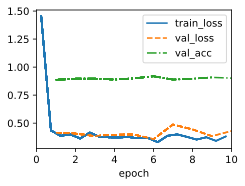

In [10]:
model_ReLU = MLP_ReLU(num_outputs=10, num_hiddens=128, lr=0.1)
trainer_ReLU = d2l.Trainer(max_epochs=10)
trainer_ReLU.fit(model_ReLU, data)
print('Final validation accuracy: ', evaluate_accuracy(model_ReLU, data.val_dataloader()))

### 2d) Redes maiores

In [11]:
class MLP_256(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(nn.Flatten(), nn.LazyLinear(num_hiddens),
                                 nn.ReLU(), nn.LazyLinear(num_outputs))
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

Final validation accuracy:  0.9786


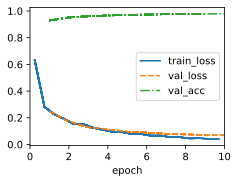

In [12]:
model_256 = MLP_256(num_outputs=10, num_hiddens=256, lr=0.001)
trainer = d2l.Trainer(max_epochs=10)

trainer.fit(model_256, data)
print('Final validation accuracy: ', evaluate_accuracy(model_256, data.val_dataloader()))

In [13]:
class MLP_2Layers(d2l.Classifier):
    def __init__(self, num_outputs=10, num_hiddens1=128, num_hiddens2=64, lr=0.001):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, num_hiddens1),
            nn.ReLU(),
            nn.Linear(num_hiddens1, num_hiddens2),
            nn.ReLU(),
            nn.Linear(num_hiddens2, num_outputs)
        )
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr, weight_decay=1e-5)

Acurácia (2 camadas: 128→64): 97.53%


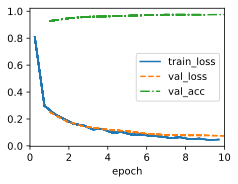

In [14]:
model_2layers = MLP_2Layers(num_hiddens1=128, num_hiddens2=64, lr=0.001)
trainer = d2l.Trainer(max_epochs=10)

trainer.fit(model_2layers, data)

val_acc_2layers = evaluate_accuracy(model_2layers, data.val_dataloader())
print(f"Acurácia (2 camadas: 128→64): {val_acc_2layers:.2%}")

## 3. Vizualização
Aqui serão vizualizados padrões erroneamente classificados. É possível perceber que para muitos dos erros cometidos, um ser humano em estado pleno de consciência jamais os cometeria.

Erros do MLP Inicial:


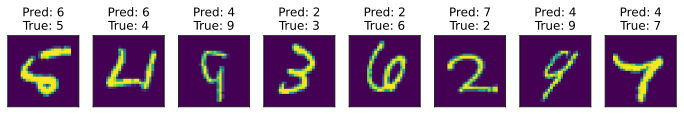

In [15]:
X_val, y_val = next(iter(dataset.val_dataloader()))
model.eval()
with torch.no_grad():
    preds_1 = torch.argmax(model(X_val), axis=1)

wrong_1 = preds_1 != y_val
X_wrong_1, y_wrong_1, preds_wrong_1= X_val[wrong_1], y_val[wrong_1], preds_1[wrong_1]

labels_1 = [f"Pred: {p.item()}\nTrue: {t.item()}" for p, t in zip(preds_wrong_1, y_wrong_1)]

print("Erros do MLP Inicial:")
dataset.visualize([X_wrong_1[:8], y_wrong_1[:8]], labels=labels_1[:8], nrows=1, ncols=8)


Erros do MLP (Adam + Sigmoid):


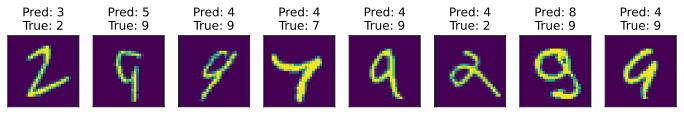

In [16]:
model_Adam.eval()
with torch.no_grad():
    preds_adam = torch.argmax(model_Adam(X_val), axis=1)
    
wrong_adam = preds_adam != y_val
X_wrong_adam, y_wrong_adam, preds_wrong_adam = X_val[wrong_adam], y_val[wrong_adam], preds_adam[wrong_adam]

# Gera rótulos
labels_adam = [f"Pred: {p.item()}\nTrue: {t.item()}" for p, t in zip(preds_wrong_adam, y_wrong_adam)]

# Visualiza (máx. 8 imagens)
print("Erros do MLP (Adam + Sigmoid):")
data.visualize([X_wrong_adam[:8], y_wrong_adam[:8]], labels=labels_adam[:8], nrows=1, ncols=8)

Erros do MLP (ReLU):


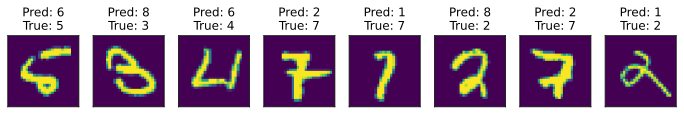

In [17]:
model_ReLU.eval()
with torch.no_grad():
    preds_relu = torch.argmax(model_ReLU(X_val), axis=1)

wrong_relu = preds_relu != y_val
X_wrong_relu, y_wrong_relu, preds_wrong_relu = X_val[wrong_relu], y_val[wrong_relu], preds_relu[wrong_relu]

labels_relu = [f"Pred: {p.item()}\nTrue: {t.item()}" for p, t in zip(preds_wrong_relu, y_wrong_relu)]

print("Erros do MLP (ReLU):")
data.visualize([X_wrong_relu[:8], y_wrong_relu[:8]], labels=labels_relu[:8], nrows=1, ncols=8)

Erros do MLP (256 neurônios):


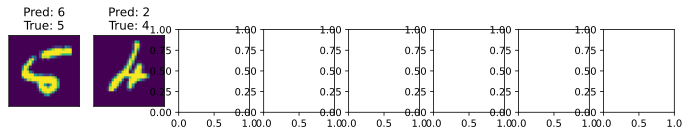

In [18]:
model_256.eval()
with torch.no_grad():
    preds_256 = torch.argmax(model_256(X_val), axis=1)

wrong_256 = preds_256 != y_val
X_wrong_256, y_wrong_256, preds_wrong_256 = X_val[wrong_256], y_val[wrong_256], preds_256[wrong_256]

labels_256 = [f"Pred: {p.item()}\nTrue: {t.item()}" for p, t in zip(preds_wrong_256, y_wrong_256)]

print("Erros do MLP (256 neurônios):")
dataset.visualize([X_wrong_256[:8], y_wrong_256[:8]], labels=labels_256[:8], nrows=1, ncols=8)

Erros do MLP (2 camadas - 128→64):


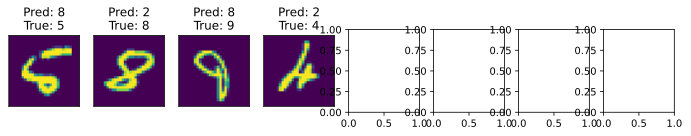

In [19]:
model_2layers.eval()
with torch.no_grad():
    preds_2l = torch.argmax(model_2layers(X_val), axis=1)

wrong_2l = preds_2l != y_val
X_wrong_2l, y_wrong_2l, preds_wrong_2l = X_val[wrong_2l], y_val[wrong_2l], preds_2l[wrong_2l]

labels_2l = [f"Pred: {p.item()}\nTrue: {t.item()}" for p, t in zip(preds_wrong_2l, y_wrong_2l)]

print("Erros do MLP (2 camadas - 128→64):")
dataset.visualize([X_wrong_2l[:8], y_wrong_2l[:8]], labels=labels_2l[:8], nrows=1, ncols=8)

## 4. Matriz de Confusão

In [20]:
cm = confusion_matrix(y_val, preds_relu)
print(cm)

[[19  0  0  0  0  0  0  0  0  0]
 [ 0 35  0  0  0  0  0  0  0  0]
 [ 0  1 22  0  0  0  0  0  1  0]
 [ 0  0  0 22  0  0  0  0  1  0]
 [ 0  0  1  0 32  0  1  0  0  0]
 [ 0  0  0  0  0 24  1  1  0  0]
 [ 0  0  0  0  0  0 21  0  1  0]
 [ 0  1  3  0  0  0  0 27  0  0]
 [ 0  0  0  0  0  0  0  0 14  0]
 [ 0  0  0  0  0  1  0  0  2 25]]


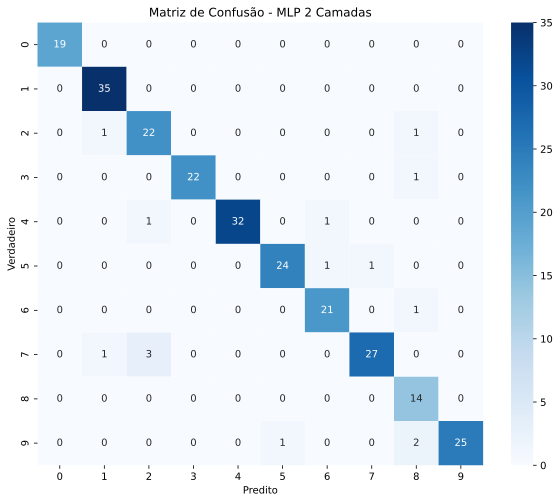

In [21]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.title('Matriz de Confusão - MLP 2 Camadas')
plt.show()

In [22]:
model_2layers.eval()
all_preds = []
all_true = []

with torch.no_grad():
    for X, y in data.val_dataloader():
        outputs = model_2layers(X)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_true.extend(y.cpu().numpy())

cm = confusion_matrix(all_true, all_preds)

confusion_analysis = {}
for true_class in range(10):
    error_counts = {pred_class: 0 for pred_class in range(10)}
    
    for pred_class in range(10):
        if pred_class != true_class:
            error_counts[pred_class] = cm[true_class, pred_class]
    
    most_confused_class = max(error_counts, key=error_counts.get)
    confusion_count = error_counts[most_confused_class]
    
    confusion_analysis[true_class] = {
        'most_confused': most_confused_class,
        'count': confusion_count,
        'all_errors': error_counts
    }

print("Análise detalhada de confusões:\n")
print(f"{'Classe':<6} | {'Mais confundida com':<20} | {'Ocorrências':<12} | Distribuição completa de erros")
print("-" * 80)

for true_class in range(10):
    analysis = confusion_analysis[true_class]
    if analysis['count'] > 0:
        error_dist = ", ".join([f"{k}:{v}" for k, v in analysis['all_errors'].items() if v > 0])
        
        print(f"{true_class:<6} | {analysis['most_confused']:<20} | "
              f"{analysis['count']:<12} | {error_dist}")
    else:
        print(f"{true_class:<6} | {'Sem erros':<20} | {'0':<12} |")

Análise detalhada de confusões:

Classe | Mais confundida com  | Ocorrências  | Distribuição completa de erros
--------------------------------------------------------------------------------
0      | 6                    | 4            | 1:1, 2:2, 3:1, 4:1, 5:1, 6:4, 8:2, 9:2
1      | 2                    | 3            | 2:3, 3:1, 5:1, 6:3, 8:3
2      | 7                    | 6            | 0:1, 1:3, 3:1, 4:2, 6:2, 7:6, 8:4
3      | 2                    | 8            | 2:8, 5:7, 7:7, 8:7, 9:4
4      | 2                    | 3            | 2:3, 5:1, 6:2, 7:2, 8:1, 9:2
5      | 3                    | 8            | 0:2, 1:1, 3:8, 4:1, 6:6, 7:1, 8:5, 9:1
6      | 0                    | 5            | 0:5, 1:3, 2:3, 3:1, 4:2, 5:3, 8:1
7      | 2                    | 11           | 0:1, 1:9, 2:11, 4:1, 8:1, 9:7
8      | 2                    | 7            | 0:5, 1:2, 2:7, 3:6, 4:5, 5:4, 6:2, 7:5, 9:3
9      | 4                    | 15           | 0:4, 1:4, 3:6, 4:15, 5:5, 7:7, 8:6


Pela análise, é possível observar que há ocorrência de confusões principalmente números: 4 e 9, 5 e 3 e 8 e 3. Essas confusões fazem sentido, visto que os pares possuem traços similares. 